# Data Dictionary


## Transaction Table *
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
## Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

# Identity Table *
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

## Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

# Import required libraries

In [1]:
import os
import glob
from pathlib import Path
import zipfile
import gc

import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

from ipywidgets import widgets, interactive
from ipykernel.pylab.backend_inline import flush_figures

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score,precision_recall_curve,f1_score,confusion_matrix,accuracy_score,roc_auc_score,roc_curve

import lightgbm as lgb

from sklearn.datasets import load_iris

%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

    
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gc

!pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import itertools
from skopt import gp_minimize
   



  Cloning git://github.com/Hvass-Labs/scikit-optimize.git (to revision dd7433da068b5a2509ef4ea4e5195458393e6555) to /tmp/pip-req-build-sh62lfhj
  Running command git clone -q git://github.com/Hvass-Labs/scikit-optimize.git /tmp/pip-req-build-sh62lfhj
  Running command git checkout -q dd7433da068b5a2509ef4ea4e5195458393e6555
  Created wheel for scikit-optimize: filename=scikit_optimize-0.5-py2.py3-none-any.whl size=77763 sha256=710895a3b098464266fb7a7f1442ed067f5adc035edd986f18e9ce807e8ea732
  Stored in directory: /tmp/pip-ephem-wheel-cache-3bmwugm_/wheels/e2/8b/7e/2956a87f1fb737a8c3f2ed18788b5e0ecfe4718141988c838f
Successfully built scikit-optimize


# data directory

In [2]:
# Attaching Drive to colab and uploads the json api key for kaggle download
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andytran","key":"6025c95aa24da57305c177e833e30853"}'}

In [3]:
!pip install -q kaggle
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
# !kaggle datasets list -s skin
!kaggle competitions download -c ieee-fraud-detection




-rw-r--r-- 1 root root 64 Nov 30 18:51 kaggle.json
 63% 33.0M/52.5M [00:00<00:00, 140MB/s]
100% 52.5M/52.5M [00:00<00:00, 175MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 201MB/s]
 70% 33.0M/47.3M [00:00<00:00, 100MB/s] 
100% 47.3M/47.3M [00:00<00:00, 157MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 201MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 159MB/s]


In [0]:
# unzips the files downloaded from kaggle 
ls = glob.glob("*.zip") 
for item in ls:
  zipfile.ZipFile(item).extractall()

!rm *.zip

# Read Data Files

In [0]:
#let see how should be the submission file
sample_submission = pd.read_csv('sample_submission.csv')
test_tran_df = pd.read_csv('test_transaction.csv')
test_identity_df = pd.read_csv('test_identity.csv')
train_tran_df = pd.read_csv('train_transaction.csv')
train_identity_df = pd.read_csv('train_identity.csv')

In [0]:
#Joining Tables
train_df = pd.merge(train_tran_df, train_identity_df, on='TransactionID', how='left')
test_df = pd.merge(test_tran_df, test_identity_df, on='TransactionID', how='left')


# EDA

## EDA - Transaction Data

In [8]:
#faud and non fraund franction
np.round(train_tran_df.isFraud.value_counts(normalize=True)*100,decimals=2) # this is a case of unbalanced data.

0    96.5
1     3.5
Name: isFraud, dtype: float64

In [9]:
#how many unique transaction ids we have?
print("Unique Transaction ids: ",len(train_tran_df.TransactionID.unique()))
print("data dim: ",train_tran_df.shape)

# no duplicates

Unique Transaction ids:  590540
data dim:  (590540, 394)


In [10]:
#ensure columns are in the correct format
catCols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
           'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
           'id_26', 'id_27', 'id_28', 'id_29','id_30', 'id_31', 'id_32',
           'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
           'DeviceInfo', 'ProductCD','card1', 'card2', 'card3',  'card5', 'card4',
           'card6','P_emaildomain','R_emaildomain', 'addr1', 'addr2',
           'M1', 'M2', 'M3', 'M4','M5', 'M6', 'M7', 'M8', 'M9']

for x in catCols:
  train_df[x].astype('category')
  test_df[x].astype('category')

train_df.head()



,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [0]:
#EDA Numerical and Categorical columns
transaction_data_columns = train_tran_df.columns
numericCols = train_tran_df._get_numeric_data().columns


In [0]:
num_Columns_Card = ['card1','card2','card3','card4','card5','card6']
num_Columns_addr = ['addr1','addr2','dist1','P_emaildomain']
num_Columns_C = train_tran_df.loc[:, 'C1':'C14'].columns
num_Columns_D = train_tran_df.loc[:, 'D1':'D15'].columns
num_Columns_V = train_tran_df.loc[:, 'V1':'V321'].columns

In [0]:
pandas_profiling.ProfileReport(train_tran_df[num_Columns_Card]).to_file("Columns_cards.html")

In [14]:
train_tran_df[num_Columns_Card].tail()

,card1,card2,card3,card4,card5,card6
590535,6550,NaN,150.0,visa,226.0,debit
590536,10444,225.0,150.0,mastercard,224.0,debit
590537,12037,595.0,150.0,mastercard,224.0,debit
590538,7826,481.0,150.0,mastercard,224.0,debit
590539,15066,170.0,150.0,mastercard,102.0,credit


decription of the data is masked, but by looking at above report we can clearly infer that these card1:card4 are card numbers, and each column has a significance. for example a unique combination of the cards will idenify a card type.

In [0]:
pandas_profiling.ProfileReport(train_tran_df[num_Columns_addr]).to_file("Columns_addr.html")

In [0]:
pandas_profiling.ProfileReport(train_tran_df[num_Columns_C]).to_file("Columns_C.html")

In [0]:
pandas_profiling.ProfileReport(train_tran_df[num_Columns_D]).to_file("Columns_D.html")

In [0]:
df_card4 = train_tran_df[['card4','isFraud']].groupby(['card4','isFraud']).size().reset_index(name='counts')
df_card6 = train_tran_df[['card6','isFraud']].groupby(['card6','isFraud']).size().reset_index(name='counts')

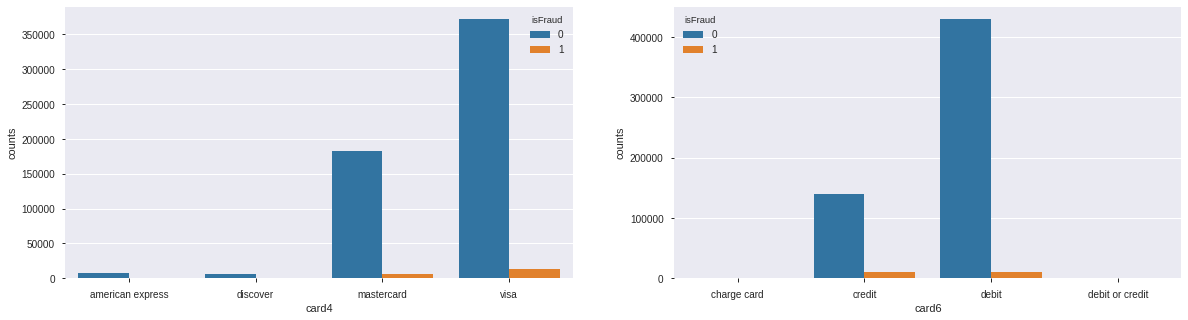

In [20]:
%matplotlib inline
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
sns.barplot(x="card4",y = 'counts', hue='isFraud', data=df_card4)
plt.subplot(1, 2, 2)
sns.barplot(x="card6",y = 'counts', hue='isFraud', data=df_card6)
plt.show()

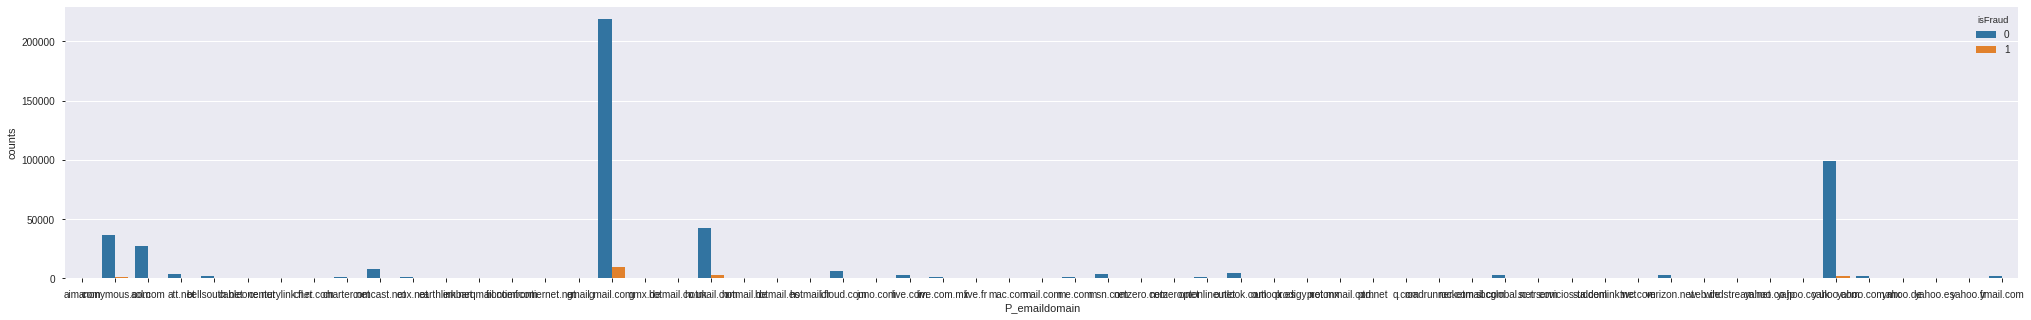

In [21]:
%matplotlib inline 
df_P_emaildomain= train_tran_df[['P_emaildomain','isFraud']].groupby(['P_emaildomain','isFraud']).size().reset_index(name='counts')
plt.figure(figsize = (35,5))
sns.barplot(x="P_emaildomain",y = 'counts', hue='isFraud', data=df_P_emaildomain)
plt.show()

## EAD - Identity data

In [22]:
train_identity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int64
id_01            144233 non-null float64
id_02            140872 non-null float64
id_03            66324 non-null float64
id_04            66324 non-null float64
id_05            136865 non-null float64
id_06            136865 non-null float64
id_07            5155 non-null float64
id_08            5155 non-null float64
id_09            74926 non-null float64
id_10            74926 non-null float64
id_11            140978 non-null float64
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float64
id_18            45113 non-null float64
id_19            139318 non-null float64
id_20            139261 non-null float64
id_21            5159 non-null float64
id_2

In [23]:
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


# Feature Engineering

Let's create some aggregations. There is no logic in them - simply aggregations on top features.



In [0]:
train_df['TransactionAmt_to_mean_card1'] = train_df['TransactionAmt'] / train_df.groupby(['card1'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_mean_card4'] = train_df['TransactionAmt'] / train_df.groupby(['card4'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_std_card1'] = train_df['TransactionAmt'] / train_df.groupby(['card1'])['TransactionAmt'].transform('std')
train_df['TransactionAmt_to_std_card4'] = train_df['TransactionAmt'] / train_df.groupby(['card4'])['TransactionAmt'].transform('std')

test_df['TransactionAmt_to_mean_card1'] = test_df['TransactionAmt'] / test_df.groupby(['card1'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_mean_card4'] = test_df['TransactionAmt'] / test_df.groupby(['card4'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_std_card1'] = test_df['TransactionAmt'] / test_df.groupby(['card1'])['TransactionAmt'].transform('std')
test_df['TransactionAmt_to_std_card4'] = test_df['TransactionAmt'] / test_df.groupby(['card4'])['TransactionAmt'].transform('std')

train_df['id_02_to_mean_card1'] = train_df['id_02'] / train_df.groupby(['card1'])['id_02'].transform('mean')
train_df['id_02_to_mean_card4'] = train_df['id_02'] / train_df.groupby(['card4'])['id_02'].transform('mean')
train_df['id_02_to_std_card1'] = train_df['id_02'] / train_df.groupby(['card1'])['id_02'].transform('std')
train_df['id_02_to_std_card4'] = train_df['id_02'] / train_df.groupby(['card4'])['id_02'].transform('std')

test_df['id_02_to_mean_card1'] = test_df['id_02'] / test_df.groupby(['card1'])['id_02'].transform('mean')
test_df['id_02_to_mean_card4'] = test_df['id_02'] / test_df.groupby(['card4'])['id_02'].transform('mean')
test_df['id_02_to_std_card1'] = test_df['id_02'] / test_df.groupby(['card1'])['id_02'].transform('std')
test_df['id_02_to_std_card4'] = test_df['id_02'] / test_df.groupby(['card4'])['id_02'].transform('std')


train_df['D15_to_mean_card1'] = train_df['D15'] / train_df.groupby(['card1'])['D15'].transform('mean')
train_df['D15_to_mean_card4'] = train_df['D15'] / train_df.groupby(['card4'])['D15'].transform('mean')
train_df['D15_to_std_card1'] = train_df['D15'] / train_df.groupby(['card1'])['D15'].transform('std')
train_df['D15_to_std_card4'] = train_df['D15'] / train_df.groupby(['card4'])['D15'].transform('std')

test_df['D15_to_mean_card1'] = test_df['D15'] / test_df.groupby(['card1'])['D15'].transform('mean')
test_df['D15_to_mean_card4'] = test_df['D15'] / test_df.groupby(['card4'])['D15'].transform('mean')
test_df['D15_to_std_card1'] = test_df['D15'] / test_df.groupby(['card1'])['D15'].transform('std')
test_df['D15_to_std_card4'] = test_df['D15'] / test_df.groupby(['card4'])['D15'].transform('std')

train_df['D15_to_mean_addr1'] = train_df['D15'] / train_df.groupby(['addr1'])['D15'].transform('mean')
train_df['D15_to_mean_addr2'] = train_df['D15'] / train_df.groupby(['addr2'])['D15'].transform('mean')
train_df['D15_to_std_addr1'] = train_df['D15'] / train_df.groupby(['addr1'])['D15'].transform('std')
train_df['D15_to_std_addr2'] = train_df['D15'] / train_df.groupby(['addr2'])['D15'].transform('std')

test_df['D15_to_mean_addr1'] = test_df['D15'] / test_df.groupby(['addr1'])['D15'].transform('mean')
test_df['D15_to_mean_addr2'] = test_df['D15'] / test_df.groupby(['addr2'])['D15'].transform('mean')
test_df['D15_to_std_addr1'] = test_df['D15'] / test_df.groupby(['addr1'])['D15'].transform('std')
test_df['D15_to_std_addr2'] = test_df['D15'] / test_df.groupby(['addr2'])['D15'].transform('std')



In [0]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1

    return dataframe

In [0]:
train_df = id_split(train_df)
test_df = id_split(test_df)

In [0]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))

 - Dataset has 433338 (73.4%) duplicate rows	Warning
 - C1 is highly skewed (γ1 = 23.95795965)	Skewed
 - C10 is highly correlated with C1 (ρ = 0.9582021807)	Rejected
 - C11 is highly correlated with C10 (ρ = 0.9560557324)	Rejected
 - C12 is highly correlated with C11 (ρ = 0.9156926583)	Rejected
 - C13 has 35460 (6.0%) zeros	Zeros
 - C14 is highly correlated with C11 (ρ = 0.9624645831)	Rejected
 - C2 is highly correlated with C14 (ρ = 0.9361484959)	Rejected
 - C3 is highly skewed (γ1 = 88.94974565)	Skewed
 - C3 has 588111 (99.6%) zeros	Zeros
 - C4 is highly correlated with C2 (ρ = 0.9721337741)	Rejected
 - C5 has 372435 (63.1%) zeros	Zeros
 - C6 is highly correlated with C4 (ρ = 0.9623192744)	Rejected
 - C7 is highly correlated with C2 (ρ = 0.938867028)	Rejected
 - C8 is highly correlated with C7 (ρ = 0.9829833765)	Rejected
 - C9 is highly correlated with C5 (ρ = 0.9257858192)	Rejected
         

 - D1 has 280130 (47.4%) zeros	Zeros
 - D10 has 221930 (37.6%) zeros	Zeros
 - D10 has 76022 (12.9%) missing values	Missing
 - D11 has 112281 (19.0%) zeros	Zeros
 - D11 has 279287 (47.3%) missing values	Missing
 - D15 has 174246 (29.5%) zeros	Zeros
 - D15 has 89113 (15.1%) missing values	Missing
 - 'D2 is highly correlated with D1 (ρ = 0.981311391)	Rejected'
 - D3 has 73094 (12.4%) zeros	Zeros
 - D3 has 262878 (44.5%) missing values	Missing
 - D4 has 166571 (28.2%) zeros	Zeros
 - D4 has 168922 (28.6%) missing values	Missing
 - D5 has 65377 (11.1%) zeros	Zeros
 - D5 has 309841 (52.5%) missing values	Missing

In [0]:
#Lets drop correlated features
correlated_cols = list(set(train_tran_df.loc[:, 'C1':'C14'].columns) - set(['C1','C13','C3','C5']))
train_df.drop(correlated_cols,axis = 1,inplace = True)
test_df.drop(correlated_cols,axis = 1,inplace = True)

train_df.drop(['D2'],axis = 1,inplace = True) 
test_df.drop(['D2'],axis = 1,inplace = True)

In [29]:
#Creating date time feature 
train_df['Transaction_dow'] = np.floor((train_df['TransactionDT'] / (3600 * 24)-1) % 7)#day of a week from some referance day
test_df['Transaction_dow'] = np.floor((test_df['TransactionDT'] / (3600 * 24)-1) % 7)#day of a week from some referance day
test_df['Transaction_hour'] = np.floor(test_df['TransactionDT'] / 3600) % 24 # hour of the day
train_df['Transaction_hour'] = np.floor(train_df['TransactionDT'] / 3600) % 24 # hour of the day

pd.crosstab(train_df['Transaction_dow'],train_df.isFraud).transpose()
pd.crosstab(train_df['Transaction_hour'],train_df.isFraud).transpose()

Transaction_hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
isFraud,,,,,,,,,,,,,,,,,,,,,,,,
0,36609,31770,25730,20005,14069,9019,5540,3311,2350,2256,3434,6562,12072,19850,27642,32999,37556,39439,40172,40652,40350,40225,39794,38471
1,1186,1027,1002,797,770,682,467,393,241,223,193,265,379,465,686,860,1142,1284,1467,1463,1432,1416,1345,1478


In [0]:
# New feature - log of transaction amount.
train_df['TransactionAmt_Log'] = np.log(train_df['TransactionAmt'])
test_df['TransactionAmt_Log'] = np.log(test_df['TransactionAmt'])


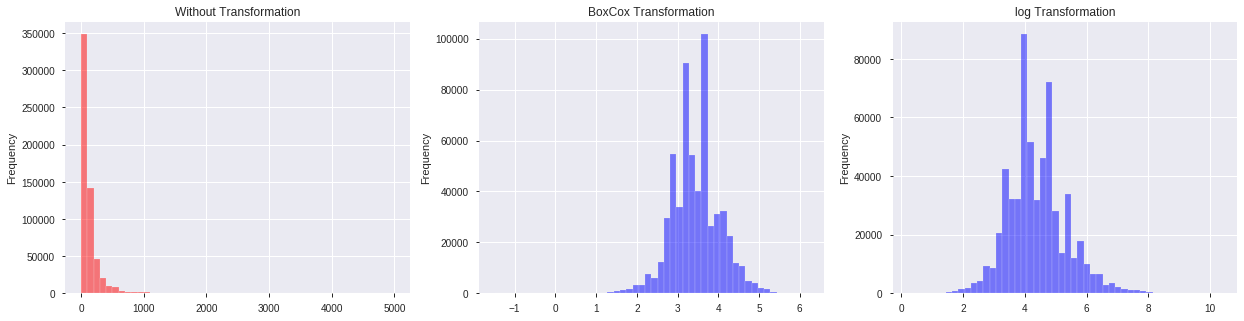

In [31]:
#Log transoformation and box cox transformation 
%matplotlib inline
plt.subplot(1, 3, 1)
(train_df.TransactionAmt).plot.hist(bins=50, figsize=(21, 5),color = 'red',alpha = 0.5 ,edgecolor = 'white', range = [0, 5000],title = 'Without Transformation')

plt.subplot(1, 3, 2)
pd.Series(boxcox(train_df.TransactionAmt)[0]).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'BoxCox Transformation')

plt.subplot(1, 3, 3)
np.log(train_df.TransactionAmt+1).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'log Transformation')

plt.show()

In [0]:
# New feature - decimal part of the transaction amount.
train_df['TransactionAmt_decimal'] = ((train_df['TransactionAmt'] - train_df['TransactionAmt'].astype(int)) * 1000).astype(int)
test_df['TransactionAmt_decimal'] = ((test_df['TransactionAmt'] - test_df['TransactionAmt'].astype(int)) * 1000).astype(int)

In [0]:
#Creat test data for quick model validation
createActualModelData = 1 # set to 1 to actual model run

if createActualModelData == 0:
  X, y = load_iris(return_X_y=True)
  X = pd.DataFrame(X)
  y[y == 2] = 0
  y = pd.DataFrame(y)
  
if createActualModelData == 1:
#Preparing Data for modeling 
  X = train_df.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1).copy()
  y = train_df.sort_values('TransactionDT')['isFraud'].copy()
  X_test = test_df.drop(['TransactionDT','TransactionID'], axis=1).copy()

In [0]:
#splitting test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [0]:
# random under sampling 
no_frauds = len(X_train[y_train == 0])
yes_frauds = len(X_train[y_train == 1])
non_fraud_indices = X_train[y_train == 0].index
random_indices = np.random.choice(non_fraud_indices, size = yes_frauds, replace=False)
fraud_indices =  X_train[y_train == 1].index
under_sample_indices = np.concatenate([fraud_indices,random_indices])

X_resampled = X_train.loc[under_sample_indices].copy()
y_resampled = y_train.loc[under_sample_indices].copy()

In [36]:
#run Logistic Regression, Decision tree, and random forest 

modelcompare = pd.DataFrame(columns=['Precision score','Recall score','Accuracy score','F1 score','AUC Score']
                             ,index =['LogisticRegression','DecisionTree', 'RandomForestClassifier','LGBM_SMOOT','LGBM','LGBM_Undersampling'])    
   
# logistic regression model
def ZlogRegression(X_train, X_test, y_train, y_test,df):
    c = .1
    logreg = LogisticRegression(class_weight='balanced',penalty='l1', C=c, solver='liblinear').fit(X_train.replace([np.inf, -np.inf, np.nan], 0), y_train)
    y_pred = logreg.predict(X_test.replace([np.inf, -np.inf, np.nan], 0))
    df.loc['LogisticRegression'] = pd.Series({'Precision score':precision_score(y_test,y_pred)
                                   , 'Recall score':recall_score(y_test,y_pred)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred)
                                   , 'F1 score':f1_score(y_test,y_pred)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})
    print('LogisticRegression')
    print(confusion_matrix(y_test, y_pred))
    print(df.loc['LogisticRegression'])
    return (df)

def Zdecisiontree(X_train, X_test, y_train, y_test,df):   
#decision tree model by tuning the proper parameters    
    opt_tree = DecisionTreeClassifier(random_state = 0)
    param_DT = {"max_depth": range(1,10),
               "min_samples_split": range(2,10,1),
               "max_leaf_nodes": range(2,5)}
    grid_tree = GridSearchCV(opt_tree,param_DT,cv=5)
    grid_tree.fit(X_train.replace([np.inf, -np.inf, np.nan], 0),y_train)
    print("The best decision tree parameters are " + str(grid_tree.best_params_)) #report the best parameters
    y_pred = grid_tree.predict(X_test.replace([np.inf, -np.inf, np.nan], 0))
    df.loc['DecisionTree'] = pd.Series({'Precision score':precision_score(y_test,y_pred)
                                   , 'Recall score':recall_score(y_test,y_pred)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred)
                                   , 'F1 score':f1_score(y_test,y_pred)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})
    print('DecisionTree')
    print(confusion_matrix(y_test, y_pred))  
    print(df.loc['DecisionTree']) 
    
#Use the same parameters to train a random forest model  
    rnd_clf = RandomForestClassifier(n_estimators=500,**grid_tree.best_params_, n_jobs=-1, random_state=42)
    rnd_clf.fit(X_train.replace([np.inf, -np.inf, np.nan], 0), y_train)
    y_pred = rnd_clf.predict(X_test.replace([np.inf, -np.inf, np.nan], 0))
    df.loc['RandomForestClassifier'] = pd.Series({'Precision score':precision_score(y_test,y_pred)
                                   , 'Recall score':recall_score(y_test,y_pred)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred)
                                   , 'F1 score':f1_score(y_test,y_pred)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})
    print('RandomForestClassifier')
    print(confusion_matrix(y_test, y_pred))  
    print(df.loc['RandomForestClassifier']) 
    
    return (df)


modelcompare = ZlogRegression(X_resampled, X_test, y_resampled, y_test, modelcompare)
modelcompare = Zdecisiontree(X_resampled, X_test, y_resampled, y_test, modelcompare)



LogisticRegression
[[118402  24012]
 [  1408   3813]]
Precision score    0.137035
Recall score        0.73032
Accuracy score     0.827819
F1 score           0.230769
AUC Score          0.780856
Name: LogisticRegression, dtype: object
The best decision tree parameters are {'max_depth': 3, 'max_leaf_nodes': 4, 'min_samples_split': 2}
DecisionTree
[[126325  16089]
 [  2514   2707]]
Precision score     0.14402
Recall score       0.518483
Accuracy score     0.873993
F1 score           0.225424
AUC Score          0.702755
Name: DecisionTree, dtype: object
RandomForestClassifier
[[115070  27344]
 [  1790   3431]]
Precision score    0.111487
Recall score       0.657154
Accuracy score     0.802662
F1 score           0.190632
AUC Score          0.732575
Name: RandomForestClassifier, dtype: object


In [0]:
#Standard Light GBM data prep
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=catCols, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=catCols, free_raw_data=False)

In [90]:
#hyper paramter optimization , Bayesian optimization using Gaussian Processes for light GBM
space  = [Integer(2, 100, name='max_depth'),
          Integer(6, 500, name='num_leaves'),
          Integer(50, 500, name='min_child_samples'),
          Real(1, 1000,  name='scale_pos_weight'),
          Real(0.0,1.0, name='min_child_weight'),
          Integer(50, 255, name='max_bin')
         ]

def objective(values):
    

    params = {'max_depth': values[0], 
             'num_leaves': values[1], 
             'min_child_samples': values[2], 
             'scale_pos_weight': values[3],
             'min_child_weight': values[4],
             'max_bin': values[5], 
             'metric':'auc',
             'boosting_type': 'gbdt',
             'objective': 'binary',
             'learning_rate':0.1,

             'application': 'binary',
             'objective': 'binary'}
    
    print('\n')
    print(params)
    
    evals_results = {}

    model_lgb     = lgb.train(params,
                              train_data,
                              valid_sets=[train_data, test_data],  
                              evals_result=evals_results, 
                              num_boost_round=300,
                              early_stopping_rounds=50,
                              verbose_eval=None, 
                              feval=None)
    
    auc = -roc_auc_score(y_test, model_lgb.predict(X_test[model_lgb.feature_name()]))
    print('AUC:',-auc,"iter:", model_lgb.current_iteration())
    gc.collect()

    return  auc


results_gp = gp_minimize(objective, 
                     space, 
                     n_calls=200,
                     random_state=0)

print("Optimal Score=%.7f" % results_gp.fun )
print("Best Parameters= " + str(results_gp.x) )






{'max_depth': 60, 'num_leaves': 423, 'min_child_samples': 436, 'scale_pos_weight': 847.4044870453415, 'min_child_weight': 0.6235636967859725, 'max_bin': 129, 'metric': 'auc', 'boosting_type': 'gbdt', 'objective': 'binary', 'learning_rate': 0.1, 'application': 'binary'}
AUC: 0.9668345117683189 iter: 246


{'max_depth': 31, 'num_leaves': 34, 'min_child_samples': 173, 'scale_pos_weight': 478.1874522040286, 'min_child_weight': 0.8121687287754934, 'max_bin': 148, 'metric': 'auc', 'boosting_type': 'gbdt', 'objective': 'binary', 'learning_rate': 0.1, 'application': 'binary'}
AUC: 0.9599503253806966 iter: 300


{'max_depth': 40, 'num_leaves': 419, 'min_child_samples': 202, 'scale_pos_weight': 648.5237001791461, 'min_child_weight': 0.368241539840548, 'max_bin': 246, 'metric': 'auc', 'boosting_type': 'gbdt', 'objective': 'binary', 'learning_rate': 0.1, 'application': 'binary'}
AUC: 0.9663468335048064 iter: 225


{'max_depth': 16, 'num_leaves': 436, 'min_child_samples': 263, 'scale_pos_weight':

In [0]:
#Optimal Score=-0.9752246
#Best Parameters= [36, 358, 500, 1.0, 1.0, 255]

In [91]:
#Light GBM model 

# parameters from hyper parameter optimization 
parameters = {'max_depth': results_gp.x[0], 
             'num_leaves': results_gp.x[1], 
             'min_child_samples': results_gp.x[2], 
             'scale_pos_weight': results_gp.x[3],
             'min_child_weight': results_gp.x[4],
             'max_bin': results_gp.x[5], 
             'metric':'auc',
             'boosting_type': 'gbdt',
             'objective': 'binary',
             'learning_rate':0.01,

             'application': 'binary',
             'objective': 'binary'}

# running light GBM model 
model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=10000,
                       verbose_eval=500,
                       early_stopping_rounds=300)

# creating valid y preditions from confusion matrix and scores
y_pred = model.predict(X_test)
y_pred_valid = y_pred.copy()
y_pred_valid_class = y_pred.copy()
y_pred_valid_class[np.where(y_pred_valid>=.5)]=1
y_pred_valid_class[np.where(y_pred_valid<=.5)]=0

print('LGBM')
print(confusion_matrix(y_test, y_pred_valid_class))  

print({'Precision score':precision_score(y_test,y_pred_valid_class)
                                   , 'Recall score':recall_score(y_test,y_pred_valid_class)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred_valid_class)
                                   , 'F1 score':f1_score(y_test,y_pred_valid_class)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})


modelcompare.loc['LGBM'] = pd.Series({'Precision score':precision_score(y_test,y_pred_valid_class)
                                   , 'Recall score':recall_score(y_test,y_pred_valid_class)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred_valid_class)
                                   , 'F1 score':f1_score(y_test,y_pred_valid_class)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})




Training until validation scores don't improve for 300 rounds.
[500]	valid_0's auc: 0.966169
[1000]	valid_0's auc: 0.973627
[1500]	valid_0's auc: 0.975434
[2000]	valid_0's auc: 0.975955
Early stopping, best iteration is:
[2118]	valid_0's auc: 0.976007
LGBM
[[142300    114]
 [  1510   3711]]
{'Precision score': 0.9701960784313726, 'Recall score': 0.7107833748324076, 'Accuracy score': 0.9889998983980763, 'F1 score': 0.8204731372982534, 'AUC Score': 0.9760069745160059}


"\nTraining until validation scores don't improve for 300 rounds.\n[500]\tvalid_0's auc: 0.944726\n[1000]\tvalid_0's auc: 0.959432\n[1500]\tvalid_0's auc: 0.964588\n[2000]\tvalid_0's auc: 0.967016\n[2500]\tvalid_0's auc: 0.968289\n[3000]\tvalid_0's auc: 0.969039\n[3500]\tvalid_0's auc: 0.969531\n[4000]\tvalid_0's auc: 0.969834\n[4500]\tvalid_0's auc: 0.970127\n[5000]\tvalid_0's auc: 0.970428\n[5500]\tvalid_0's auc: 0.970671\n[6000]\tvalid_0's auc: 0.97084\n[6500]\tvalid_0's auc: 0.97091\n[7000]\tvalid_0's auc: 0.970973\nEarly stopping, best iteration is:\n[6865]\tvalid_0's auc: 0.970989\n----------------------------------\n"

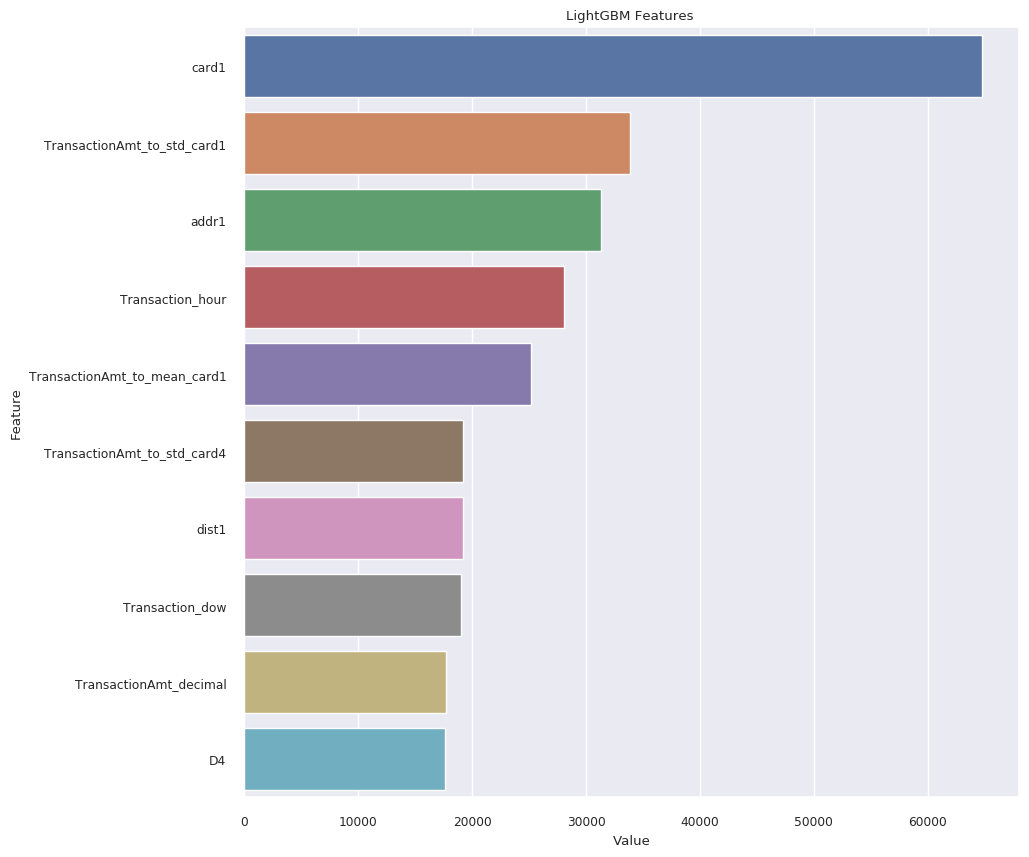

In [92]:
#Plot feature importiance for light GBM 
feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X_train.columns})
plt.figure(figsize=(10, 10))

sns.set(font_scale = 0.8)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:10])
plt.title('LightGBM Features ')
plt.savefig('lgbm_importances-01.png')
plt.show()


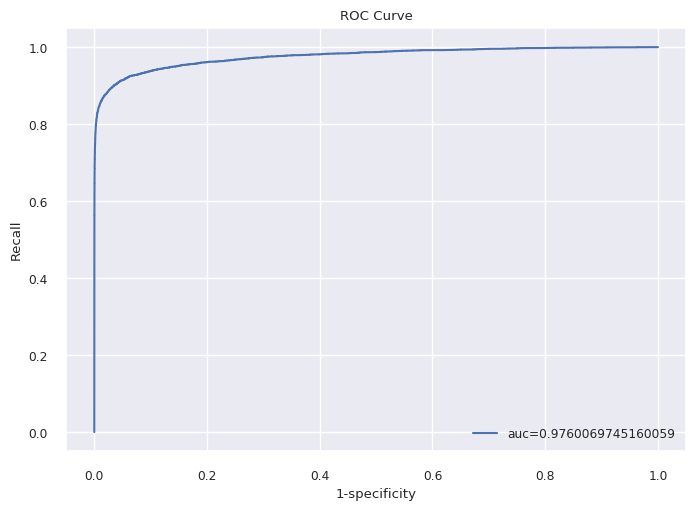

In [93]:
#ROC curve for Light GBM 
y_pred_proba = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('Recall')
plt.xlabel('1-specificity')
plt.title('ROC Curve')
plt.show()

In [94]:
#Light GBM with under sampling 
train_data = lgb.Dataset(X_resampled, label=y_resampled, categorical_feature=catCols)
test_data = lgb.Dataset(X_test, label=y_test)




model_under = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=10000,
                       verbose_eval=500,
                       early_stopping_rounds=300)

y_pred = model_under.predict(X_test)
y_pred_valid = y_pred.copy()
y_pred_valid_class[np.where(y_pred_valid>=.5)]=1
y_pred_valid_class[np.where(y_pred_valid<=.5)]=0

print('LGBM_Undersampling')
print(confusion_matrix(y_test, y_pred_valid_class))  

print({'Precision score':precision_score(y_test,y_pred_valid_class)
                                   , 'Recall score':recall_score(y_test,y_pred_valid_class)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred_valid_class)
                                   , 'F1 score':f1_score(y_test,y_pred_valid_class)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})


modelcompare.loc['LGBM_Undersampling'] = pd.Series({'Precision score':precision_score(y_test,y_pred_valid_class)
                                   , 'Recall score':recall_score(y_test,y_pred_valid_class)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred_valid_class)
                                   , 'F1 score':f1_score(y_test,y_pred_valid_class)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})



Training until validation scores don't improve for 300 rounds.
[500]	valid_0's auc: 0.931458
[1000]	valid_0's auc: 0.945422
[1500]	valid_0's auc: 0.95169
[2000]	valid_0's auc: 0.955345
[2500]	valid_0's auc: 0.957544
[3000]	valid_0's auc: 0.959143
[3500]	valid_0's auc: 0.960227
[4000]	valid_0's auc: 0.961207
[4500]	valid_0's auc: 0.961794
[5000]	valid_0's auc: 0.962289
[5500]	valid_0's auc: 0.962707
[6000]	valid_0's auc: 0.962968
[6500]	valid_0's auc: 0.963278
[7000]	valid_0's auc: 0.963473
[7500]	valid_0's auc: 0.96364
[8000]	valid_0's auc: 0.963785
[8500]	valid_0's auc: 0.963961
[9000]	valid_0's auc: 0.964063
[9500]	valid_0's auc: 0.964168
[10000]	valid_0's auc: 0.964284
Did not meet early stopping. Best iteration is:
[9973]	valid_0's auc: 0.964285
LGBM_Undersampling
[[129567  12847]
 [   512   4709]]
{'Precision score': 0.26822738664843926, 'Recall score': 0.9019344953074123, 'Accuracy score': 0.9095133267856538, 'F1 score': 0.41348728980989585, 'AUC Score': 0.9642853898739111}


In [95]:
# print model results 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
  print(modelcompare)
print ("The model with the highest precision score is " + str(modelcompare[modelcompare['Precision score'] == modelcompare['Precision score'].max()].index.values))
print ("The model with the highest recall score is " + str(modelcompare[modelcompare['Recall score'] == modelcompare['Recall score'].max()].index.values))
print ("The model with the highest accuracy score is " + str(modelcompare[modelcompare['Accuracy score'] == modelcompare['Accuracy score'].max()].index.values))
print ("The model with the highest F1 score is " + str(modelcompare[modelcompare['F1 score'] == modelcompare['F1 score'].max()].index.values))
print ("The model with the highest AUC score is " + str(modelcompare[modelcompare['AUC Score'] == modelcompare['AUC Score'].max()].index.values))



                       Precision score Recall score Accuracy score  F1 score  \
LogisticRegression            0.137035      0.73032       0.827819  0.230769   
DecisionTree                   0.14402     0.518483       0.873993  0.225424   
RandomForestClassifier        0.111487     0.657154       0.802662  0.190632   
LGBM_SMOOT                         NaN          NaN            NaN       NaN   
LGBM                          0.970196     0.710783          0.989  0.820473   
LGBM_Undersampling            0.268227     0.901934       0.909513  0.413487   

                       AUC Score  
LogisticRegression      0.780856  
DecisionTree            0.702755  
RandomForestClassifier  0.732575  
LGBM_SMOOT                   NaN  
LGBM                    0.976007  
LGBM_Undersampling      0.964285  
The model with the highest precision score is ['LGBM']
The model with the highest recall score is ['LGBM_Undersampling']
The model with the highest accuracy score is ['LGBM']
The model with the 

In [0]:
#create file for kaggle upload
submission = pd.DataFrame()
submission['TransactionID'] = test_df['TransactionID']
submission['isFraud'] = model.predict(test_df.drop(['TransactionDT','TransactionID'], axis=1))
submission.to_csv('ieee_cis_fraud_detection_v2.csv', index=False)


In [0]:
#submission to Kaggle 
!kaggle competitions submit ieee-fraud-detection -f ieee_cis_fraud_detection_v2.csv -m ""
 
